# Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

**Цель:** На этот раз займемся классической задачкой - сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомится со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.

## Часть 1. EDA и Preprocessing
1. Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit
2. Проведите EDA, чтобы познакомиться с признаками
3. Преобразуйте все признаки в числовые подходящими методами
4. Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации)

## Часть 2. Моделирование
1. Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot
2. Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости 

## Часть 3. Интерпретация
1. Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
2. Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

## Критерии оценки
- EDA и Preprocessing - 2 балла
- Моделирование - 5 баллов
- Интерпретация - 3 балла

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## Часть 1. EDA и Preprocessing
### 1.1 Загрузка данных

Загружаем данные из датасета по выдаче кредитов (https://www.kaggle.com/uciml/german-credit). Колонки следующие:
- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [2]:
data = pd.read_csv('german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


Получение базовых статистик датасета: средние, медиана, персентили

In [4]:
data.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


### 1.2 Анализ и предобработка переменных

Заметим, что первый столбец представляет собой индекс, можем сразу его удалить.

In [5]:
data.drop(data.columns[0], inplace=True, axis=1)
data_original = data.copy()
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


Сперва проверим, есть ли пропуски в данных.

In [6]:
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Пропуски есть в данных по счетам, скорее всего связано с тем, что у клиентов таких счетов нет. Обработаем пропуски при последовательном анализе колонок далее.

---
**Age**

In [7]:
data['Age'].unique()

array([67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 32, 44, 31, 48, 26, 36,
       39, 42, 34, 63, 27, 30, 57, 33, 37, 58, 23, 29, 52, 50, 46, 51, 41,
       40, 66, 47, 56, 54, 20, 21, 38, 70, 65, 74, 68, 43, 55, 64, 75, 19,
       62, 59])

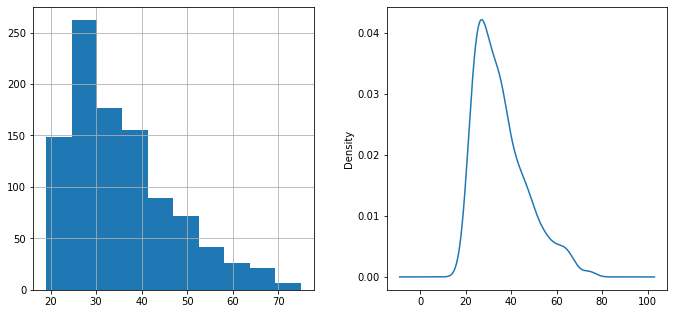

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
data['Age'].hist(ax=axs[0])
data['Age'].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

Основную массу клиентов составляют люди до 40.

---
**Sex**

In [9]:
data['Sex'].value_counts()

male      690
female    310
Name: Sex, dtype: int64

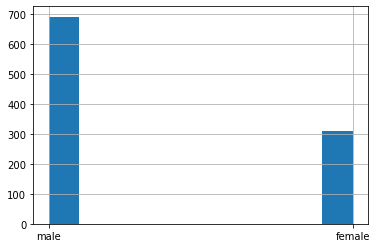

In [10]:
data['Sex'].hist()

Преобразуем в числовые данные с помощью LabelEncoder

In [11]:
label_encoder = LabelEncoder()
data['Sex_encoded'] = label_encoder.fit_transform(data['Sex'])
data.drop(['Sex'], inplace=True, axis=1)
data.head()

,Age,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_encoded
0,67,2,own,NaN,little,1169,6,radio/TV,1
1,22,2,own,little,moderate,5951,48,radio/TV,0
2,49,1,own,little,NaN,2096,12,education,1
3,45,2,free,little,little,7882,42,furniture/equipment,1
4,53,2,free,little,little,4870,24,car,1


---
**Job**

In [12]:
data['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

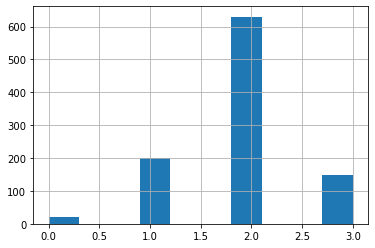

In [13]:
data['Job'].hist()

---
**Housing**

In [14]:
data['Housing'].value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

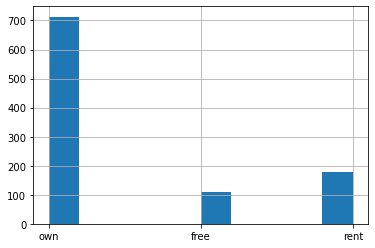

In [15]:
data['Housing'].hist()

Преобразуем в числовые данные с помощью LabelEncoder

In [16]:
data['Housing_encoded'] = label_encoder.fit_transform(data['Housing'])
data.drop(['Housing'], inplace=True, axis=1)
data.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_encoded,Housing_encoded
0,67,2,NaN,little,1169,6,radio/TV,1,1
1,22,2,little,moderate,5951,48,radio/TV,0,1
2,49,1,little,NaN,2096,12,education,1,1
3,45,2,little,little,7882,42,furniture/equipment,1,0
4,53,2,little,little,4870,24,car,1,0


---
**Saving accounts**

In [17]:
data['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

Заменим пустые значения отдельной категорией - `none`

In [18]:
data['Saving accounts'].fillna('none', inplace=True)
data_original['Saving accounts'].fillna('none', inplace=True)

In [19]:
data['Saving accounts'].value_counts()

little        603
none          183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

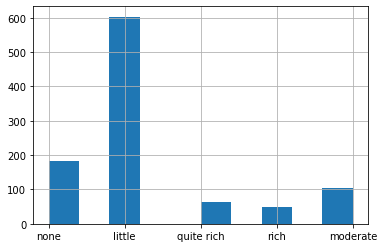

In [20]:
data['Saving accounts'].hist()

Преобразуем в числовые данные с помощью LabelEncoder

In [21]:
data['Saving accounts_encoded'] = label_encoder.fit_transform(data['Saving accounts'])
data.drop(['Saving accounts'], inplace=True, axis=1)
data.head()

,Age,Job,Checking account,Credit amount,Duration,Purpose,Sex_encoded,Housing_encoded,Saving accounts_encoded
0,67,2,little,1169,6,radio/TV,1,1,2
1,22,2,moderate,5951,48,radio/TV,0,1,0
2,49,1,NaN,2096,12,education,1,1,0
3,45,2,little,7882,42,furniture/equipment,1,0,0
4,53,2,little,4870,24,car,1,0,0


---
**Checking account**

Произведем похожую обработку и с `Checking account`.

In [22]:
data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

Заменим пустые значения отдельной категорией - `none`

In [23]:
data['Checking account'].fillna('none', inplace=True)
data_original['Checking account'].fillna('none', inplace=True)

In [24]:
data['Checking account'].value_counts()

none        394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

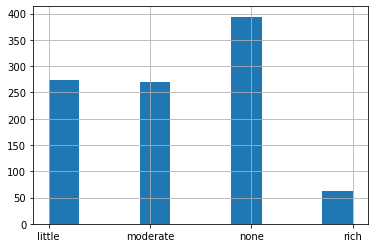

In [25]:
data['Checking account'].hist()

Преобразуем в числовые данные с помощью LabelEncoder

In [26]:
data['Checking account_encoded'] = label_encoder.fit_transform(data['Checking account'])
data.drop(['Checking account'], inplace=True, axis=1)
data.head()

,Age,Job,Credit amount,Duration,Purpose,Sex_encoded,Housing_encoded,Saving accounts_encoded,Checking account_encoded
0,67,2,1169,6,radio/TV,1,1,2,0
1,22,2,5951,48,radio/TV,0,1,0,1
2,49,1,2096,12,education,1,1,0,2
3,45,2,7882,42,furniture/equipment,1,0,0,0
4,53,2,4870,24,car,1,0,0,0


---
**Credit amount**

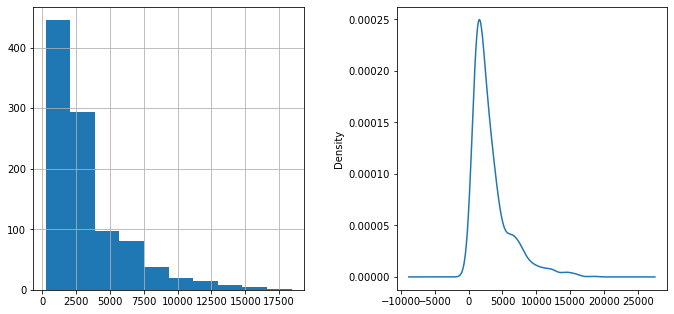

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
data['Credit amount'].hist(ax=axs[0])
data['Credit amount'].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

---
**Duration**

In [28]:
data['Duration'].value_counts()

24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
27     13
60     13
42     11
11      9
20      8
8       7
4       6
39      5
45      5
7       5
14      4
13      4
33      3
28      3
22      2
16      2
54      2
26      1
40      1
47      1
5       1
72      1
Name: Duration, dtype: int64

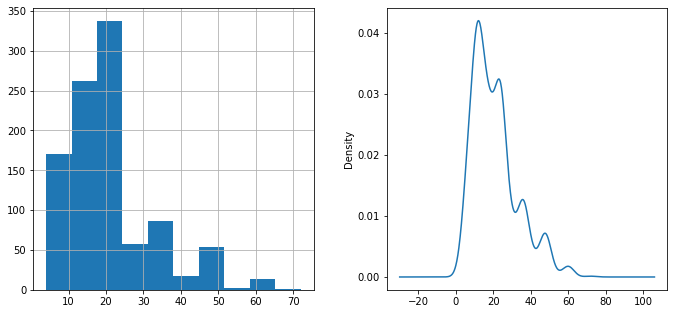

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
data['Duration'].hist(ax=axs[0])
data['Duration'].plot(kind='kde', ax=axs[1])
plt.tight_layout(pad=3.0)
plt.show()

Наиболее популярными были краткосрочные кредиты и кредиты до 2-х лет.

---
**Purpose**

In [30]:
data['Purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64

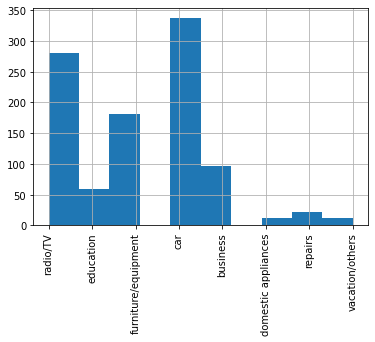

In [31]:
data['Purpose'].hist()
plt.xticks(rotation='vertical')
plt.show()

Преобразуем в числовые данные с помощью LabelEncoder

In [32]:
data['Purpose_encoded'] = label_encoder.fit_transform(data['Purpose'])
data.drop(['Purpose'], inplace=True, axis=1)
data.head()

,Age,Job,Credit amount,Duration,Sex_encoded,Housing_encoded,Saving accounts_encoded,Checking account_encoded,Purpose_encoded
0,67,2,1169,6,1,1,2,0,5
1,22,2,5951,48,0,1,0,1,5
2,49,1,2096,12,1,1,0,2,3
3,45,2,7882,42,1,0,0,0,4
4,53,2,4870,24,1,0,0,0,1


### 1.3 Шкалирование
Для кластеризация важно, чтобы данные были приведены к одному масштабу. Иначе расстояние может слабо учитывать изменения в мелких значениях и сильно реагировать на крупные значения.

In [33]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
data_scaled.head()

,Age,Job,Credit amount,Duration,Sex_encoded,Housing_encoded,Saving accounts_encoded,Checking account_encoded,Purpose_encoded
0,2.766456,0.146949,-0.745131,-1.236478,0.670280,-0.133710,0.955847,-1.344000,1.073263
1,-1.191404,0.146949,0.949817,2.248194,-1.491914,-0.133710,-0.706496,-0.265348,1.073263
2,1.183312,-1.383771,-0.416562,-0.738668,0.670280,-0.133710,-0.706496,0.813303,0.061705
3,0.831502,0.146949,1.634247,1.750384,0.670280,-2.016956,-0.706496,-1.344000,0.567484
4,1.535122,0.146949,0.566664,0.256953,0.670280,-2.016956,-0.706496,-1.344000,-0.949853


In [34]:
data_scaled.describe()

,Age,Job,Credit amount,Duration,Sex_encoded,Housing_encoded,Saving accounts_encoded,Checking account_encoded,Purpose_encoded
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,3.597123e-17,1.167400e-16,7.771561e-17,1.332268e-16,-4.418688e-17,-2.598477e-16,4.839185e-17,-5.628831e-17,-2.797762e-16
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-1.455261e+00,-2.914492e+00,-1.070865e+00,-1.402415e+00,-1.491914e+00,-2.016956e+00,-7.064959e-01,-1.344000e+00,-1.455632e+00
25%,-7.516417e-01,1.469492e-01,-6.754833e-01,-7.386675e-01,-1.491914e+00,-1.337105e-01,-7.064959e-01,-1.344000e+00,-9.498528e-01
50%,-2.239269e-01,1.469492e-01,-3.373443e-01,-2.408572e-01,6.702801e-01,-1.337105e-01,-7.064959e-01,-2.653482e-01,6.170503e-02
75%,5.676451e-01,1.469492e-01,2.484620e-01,2.569531e-01,6.702801e-01,-1.337105e-01,9.558474e-01,8.133031e-01,1.073263e+00
max,3.470076e+00,1.677670e+00,5.370789e+00,4.239436e+00,6.702801e-01,1.749535e+00,2.618191e+00,1.891955e+00,2.084821e+00


---
Все колонки обработаны и можно приступать к моделированию.

## Часть 2. Моделирование

In [35]:
X = data_scaled

### 2.1 KMeans

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Подберем оптимальное количество кластеров с помощью метода локтя и силуэт графика.

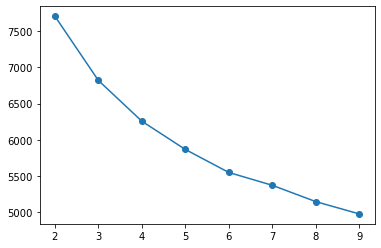

In [37]:
inertia = []
silhouette_scores = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(range(2,10), inertia, marker='o');

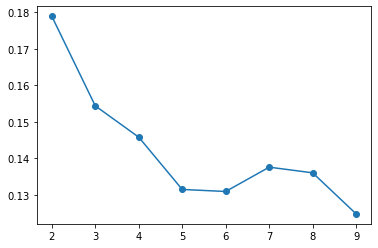

In [38]:
plt.plot(range(2,10), silhouette_scores, marker='o');

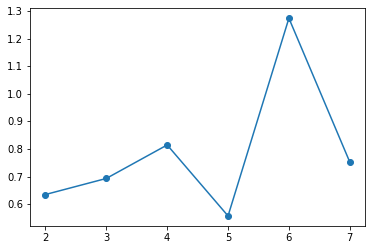

In [39]:
D = []
for i in range(1,7):
    D.append((inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i]))

plt.plot(range(2,8), D, marker='o');    

Можно сделать вывод, что оптимальным количеством кластеров будет 3 или 5.

In [40]:
kmeans = KMeans(n_clusters=5, random_state=7)
kmeans.fit(X)

data_clustered_kmeans = data_original.copy()
data_clustered_kmeans['Cluster'] = kmeans.labels_

data_clustered_kmeans.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,67,male,2,own,none,little,1169,6,radio/TV,4
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,none,2096,12,education,3
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,3


#### Визуализация

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

def visualization_by_reducer(X, clusters, reducer, name):    
    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(8, 8))
    sns.scatterplot(
        x=X_reduced[:, 0], 
        y=X_reduced[:, 1], 
        hue=clusters, 
        palette="bright",
        legend='full'
    )    
    plt.title("Data embedded into two dimensions by %s" % name, fontsize=18)
    plt.show()
    
def visualization(X, clusters):
    visualization_by_reducer(X, clusters, PCA(n_components=2), 'PCA')
    visualization_by_reducer(X, clusters, umap.UMAP(n_components=2), 'UMAP')
    visualization_by_reducer(X, clusters, TSNE(n_components=2), 'TSNE')

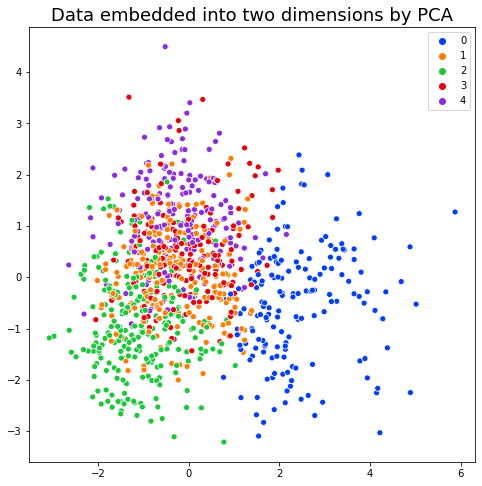

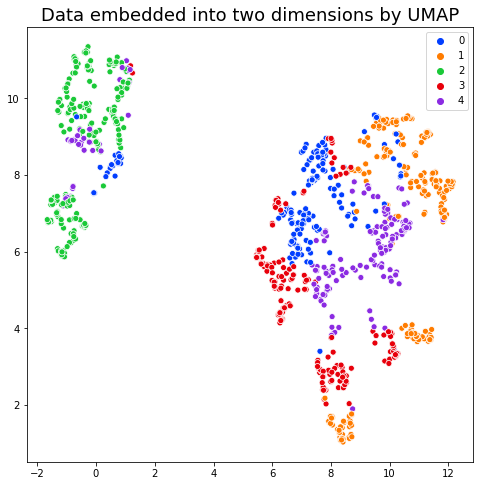

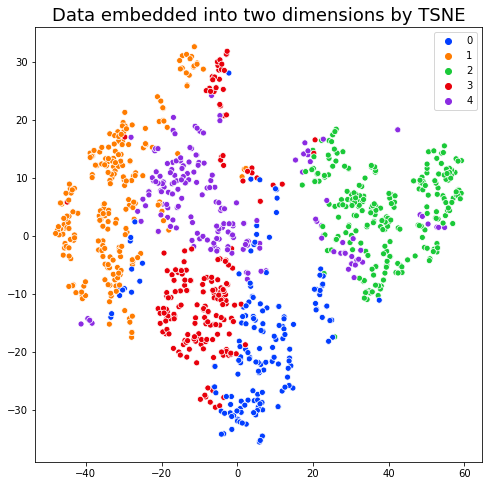

In [42]:
visualization(X, kmeans.labels_)

### 2.2 Hierarhical clustering

In [43]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

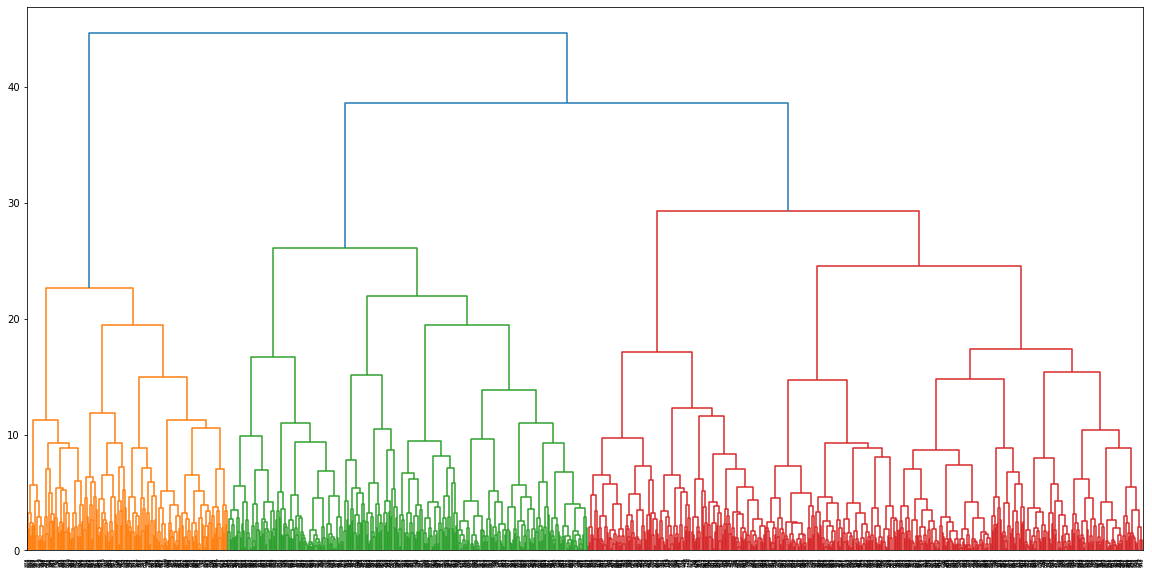

In [44]:
plt.figure(figsize=(20,10))

dendrogram = dendrogram(linkage(X, method='ward'))

Из дендограммы видно, что оптимальным количеством кластеров будет 3 или 5.

In [45]:
aggl_clustering = AgglomerativeClustering(n_clusters=3)
aggl_clustering.fit(X)

data_clustered_aggl = data_original.copy()
data_clustered_aggl['Cluster'] = aggl_clustering.labels_

data_clustered_aggl.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,67,male,2,own,none,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,none,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,1


#### Визуализация

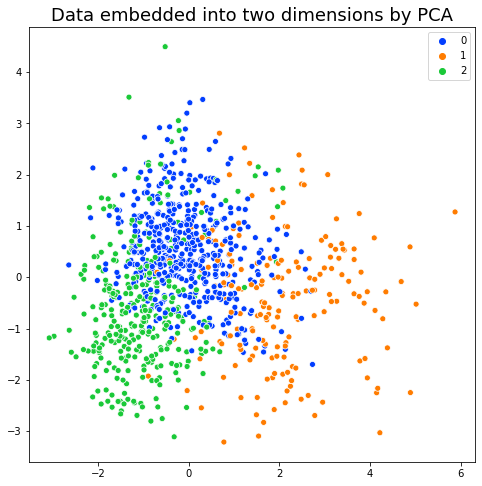

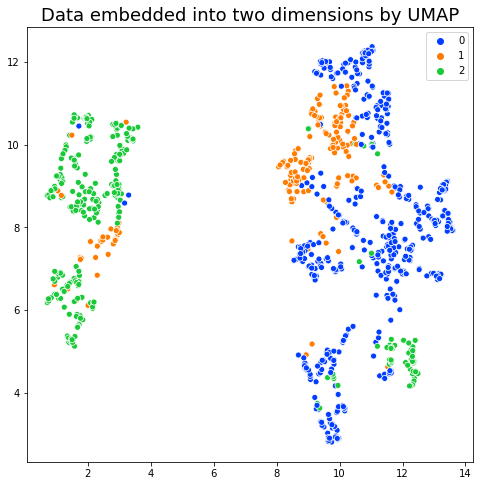

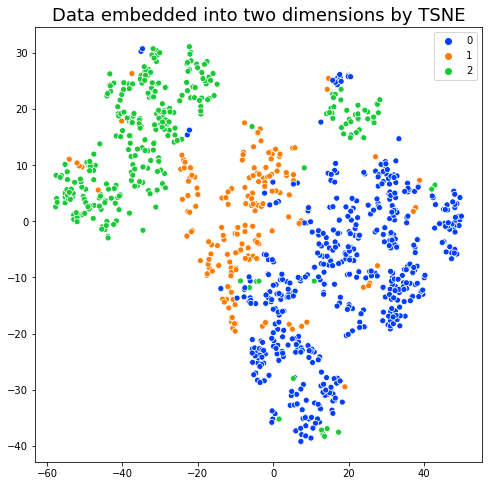

In [46]:
visualization(X, aggl_clustering.labels_)

### DBScan

In [47]:
from sklearn.cluster import DBSCAN

In [48]:
dbscan = DBSCAN()
dbscan.fit(X)

data_clustered_dbscan = data_original.copy()
data_clustered_dbscan['Cluster'] = dbscan.labels_

data_clustered_dbscan.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,67,male,2,own,none,little,1169,6,radio/TV,-1
1,22,female,2,own,little,moderate,5951,48,radio/TV,-1
2,49,male,1,own,little,none,2096,12,education,-1
3,45,male,2,free,little,little,7882,42,furniture/equipment,-1
4,53,male,2,free,little,little,4870,24,car,-1


#### Визуализация

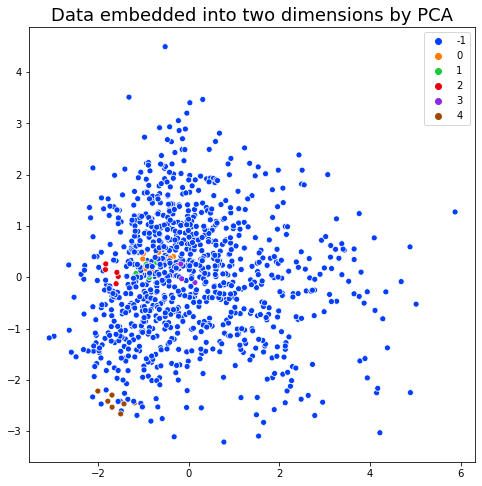

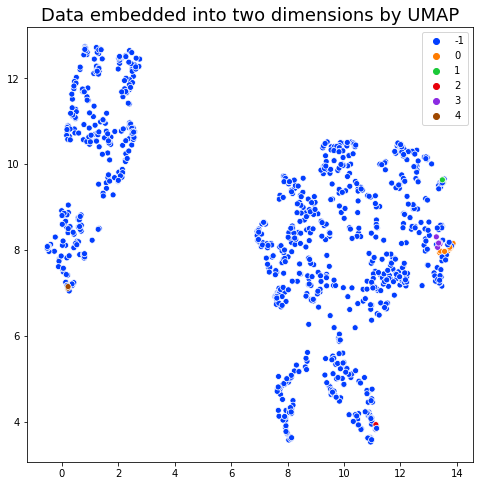

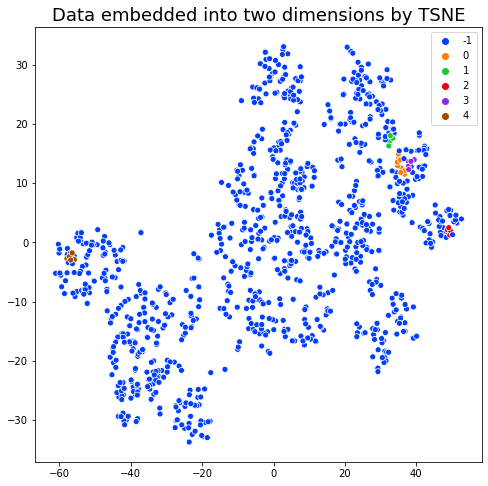

In [49]:
visualization(X, dbscan.labels_)

Как видно, DBSCAN с параметрами по умолчанию не очень хорошо справляется с текущей задачей: практически вся выборка попала в аномалии. Попробуем подобрать параметр `epsilon`.

In [50]:
threshold = 0.1
epsilon = 0.05
outlier_percentage = 1.

epsilons_history = []
clusters_history = []
outliers_history = []

while outlier_percentage > threshold:        
    dbscan = DBSCAN(eps=epsilon)
    dbscan.fit(X)
    clusters = dbscan.labels_
    
    epsilons_history.append(epsilon)
    clusters_history.append(len(np.unique(clusters)) - 1)    
    
    outlier_percentage = sum(clusters == -1) / len(clusters)
    outliers_history.append(outlier_percentage)
    
    epsilon += 0.05

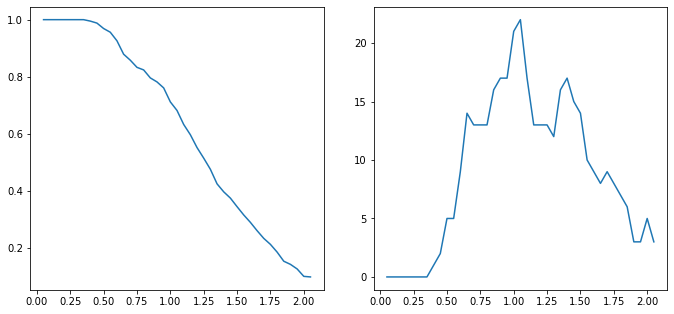

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axs[0].plot(epsilons_history, outliers_history)
axs[1].plot(epsilons_history, clusters_history)

plt.tight_layout(pad=3.0)
plt.show()

Со значением `epsilon = 2` получаем 5 кластеров и приемлимый уровень аномалий.

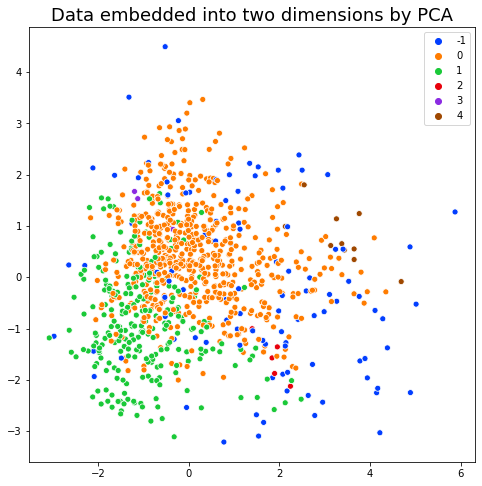

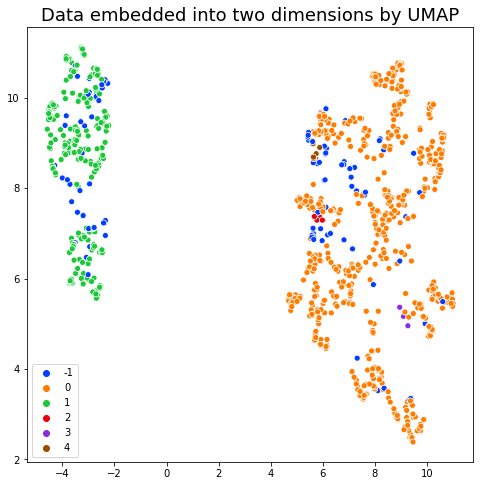

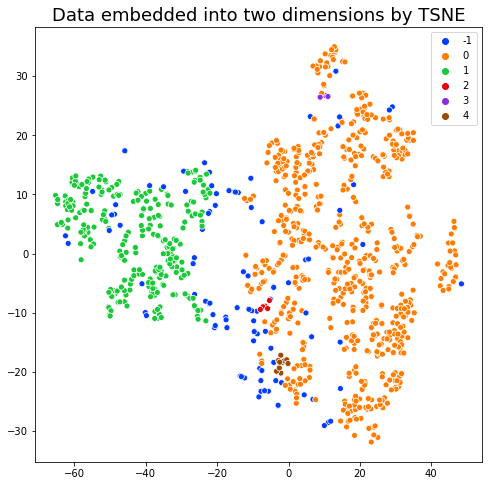

In [52]:
dbscan = DBSCAN(eps=2)
dbscan.fit(X)

data_clustered_dbscan = data_original.copy()
data_clustered_dbscan['Cluster'] = dbscan.labels_

visualization(X, dbscan.labels_)

## Часть 3. Интерпретация

### 3.1 Анализ среднего значения в кластерах

Начнем с простого расчета средних значений признаков для каждого из кластеров, будут ли интересные закономерности? Рассмотрим результаты K-Means кластеризации.

In [53]:
data_clustered_kmeans.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,67,male,2,own,none,little,1169,6,radio/TV,4
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,none,2096,12,education,3
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,3


In [54]:
data_clustered_kmeans.groupby('Cluster').mean()

,Age,Job,Credit amount,Duration
Cluster,,,,
0,37.234568,2.351852,8150.160494,38.598765
1,33.506494,1.861472,2368.095238,18.948052
2,30.698745,1.761506,2212.728033,17.087866
3,38.195767,1.740741,2384.873016,16.375661
4,40.324022,1.916201,2370.497207,17.284916


Исходя из средних значений числовых переменных, можно заметить определенные закономерности. Так, например, кластер 0 выделяется суммой и продолжительностью кредита, а также квалификацией. Остальные закономерности посмотрим подробнее при визуализации всех переменных.

### 3.2 Визуализация кластеров

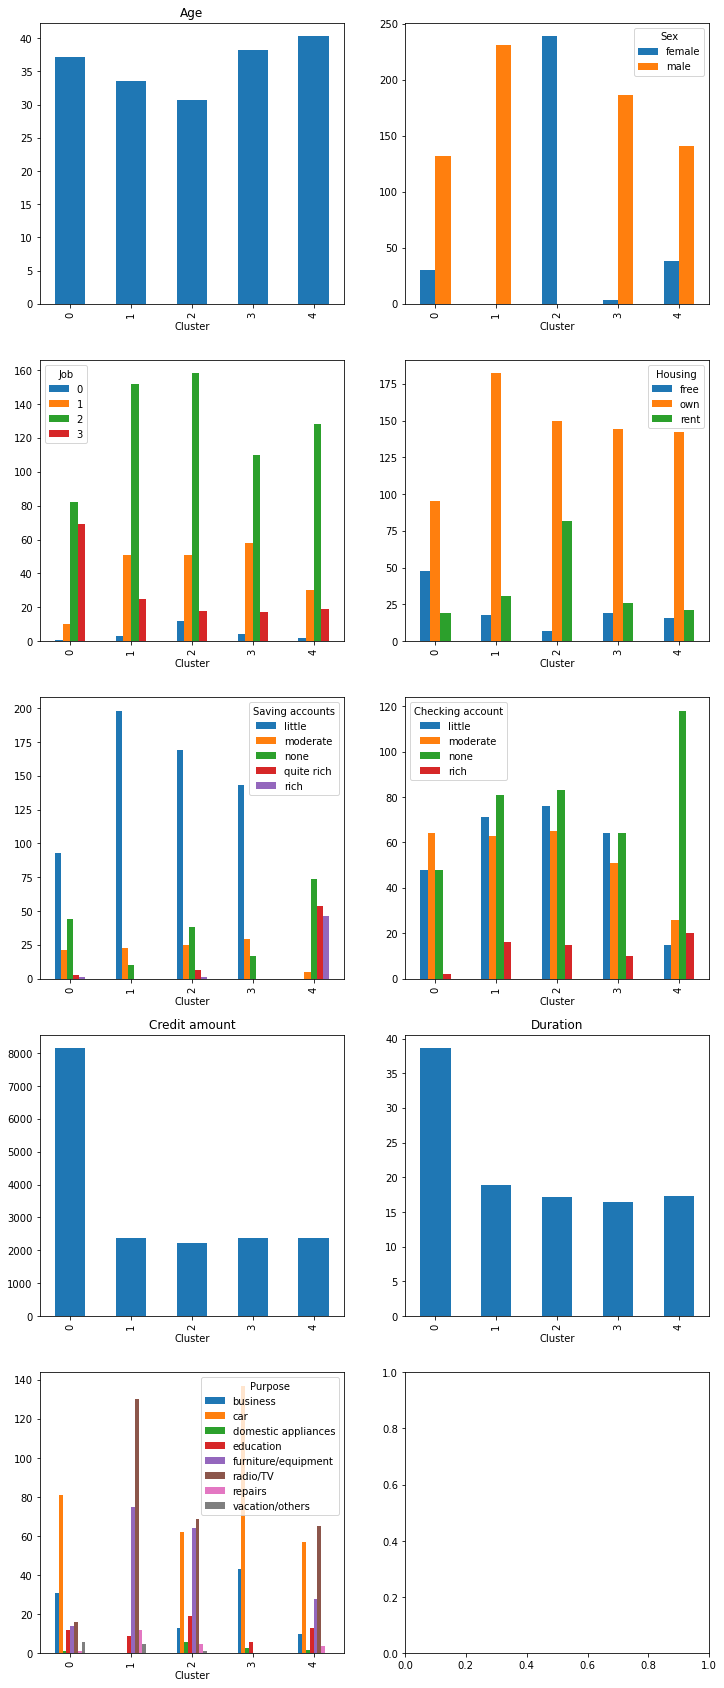

In [55]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12,30))

data_clustered_kmeans.groupby(['Cluster']).mean()['Age'].plot(kind='bar', ax=axs[0, 0])
data_clustered_kmeans.groupby(['Cluster', 'Sex']).size().unstack().plot(kind='bar', ax=axs[0, 1])
data_clustered_kmeans.groupby(['Cluster', 'Job']).size().unstack().plot(kind='bar', ax=axs[1, 0])
data_clustered_kmeans.groupby(['Cluster', 'Housing']).size().unstack().plot(kind='bar', ax=axs[1, 1])
data_clustered_kmeans.groupby(['Cluster', 'Saving accounts']).size().unstack().plot(kind='bar', ax=axs[2, 0])
data_clustered_kmeans.groupby(['Cluster', 'Checking account']).size().unstack().plot(kind='bar', ax=axs[2, 1])
data_clustered_kmeans.groupby(['Cluster']).mean()['Credit amount'].plot(kind='bar', ax=axs[3, 0])
data_clustered_kmeans.groupby(['Cluster']).mean()['Duration'].plot(kind='bar', ax=axs[3, 1])
data_clustered_kmeans.groupby(['Cluster', 'Purpose']).size().unstack().plot(kind='bar', ax=axs[4, 0])

axs[0, 0].set_title('Age')
axs[3, 0].set_title('Credit amount')
axs[3, 1].set_title('Duration')

plt.show()

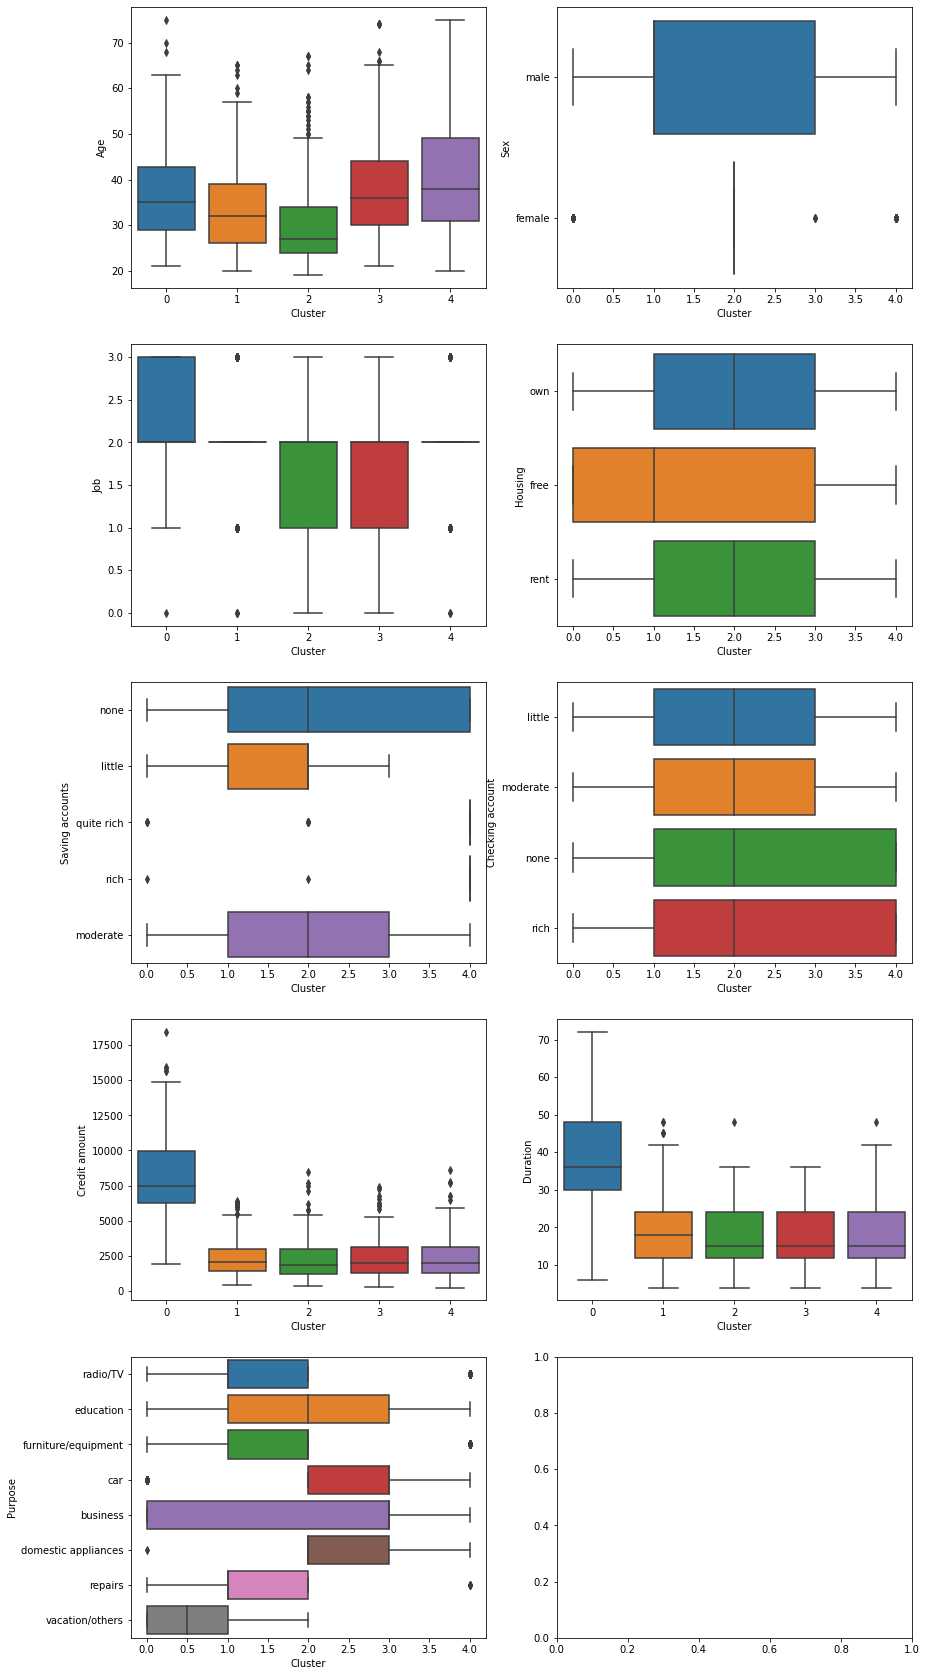

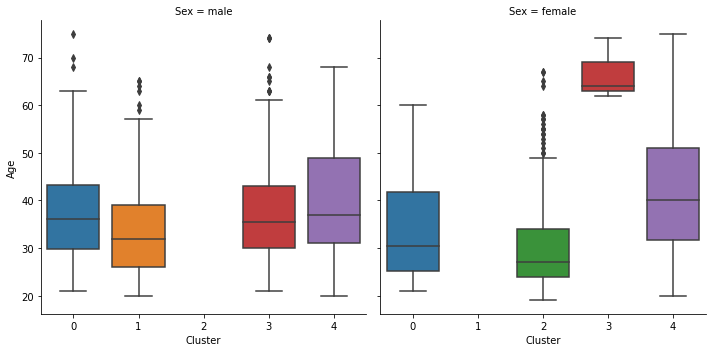

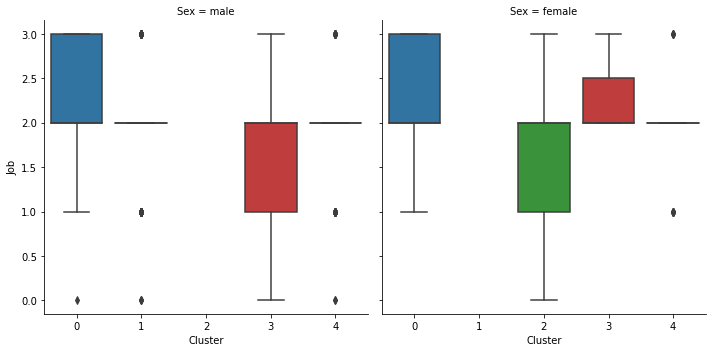

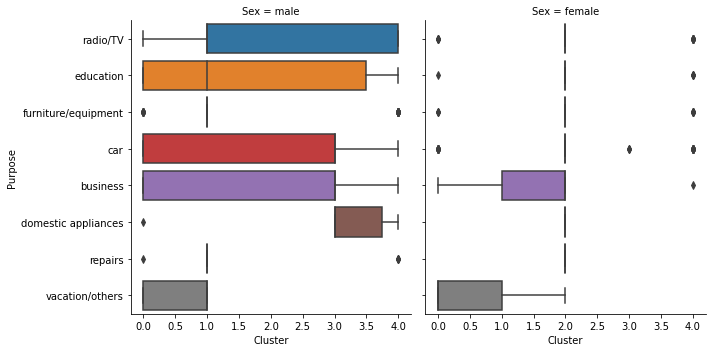

In [56]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,30))

sns.boxplot(x='Cluster', y='Age', data=data_clustered_kmeans, ax=axs[0, 0])
sns.boxplot(x='Cluster', y='Sex', data=data_clustered_kmeans, ax=axs[0, 1])
sns.boxplot(x='Cluster', y='Job', data=data_clustered_kmeans, ax=axs[1, 0])
sns.boxplot(x='Cluster', y='Housing', data=data_clustered_kmeans, ax=axs[1, 1])
sns.boxplot(x='Cluster', y='Saving accounts', data=data_clustered_kmeans, ax=axs[2, 0])
sns.boxplot(x='Cluster', y='Checking account', data=data_clustered_kmeans, ax=axs[2, 1])
sns.boxplot(x='Cluster', y='Credit amount', data=data_clustered_kmeans, ax=axs[3, 0])
sns.boxplot(x='Cluster', y='Duration', data=data_clustered_kmeans, ax=axs[3, 1])
sns.boxplot(x='Cluster', y='Purpose', data=data_clustered_kmeans, ax=axs[4, 0])

sns.catplot(x='Cluster', y='Age', data=data_clustered_kmeans, kind="box", col='Sex')
sns.catplot(x='Cluster', y='Job', data=data_clustered_kmeans, kind="box", col='Sex')
sns.catplot(x='Cluster', y='Purpose', data=data_clustered_kmeans, kind="box", col='Sex')

plt.show()

Исходя из графиков можно заметить следующие закономерности:
* Как можно заметить, кластер 3 сильно отличается для мужчин и женщин по возрастному признаку и квалификации (у женщин в этом кластере возраст и квалификация значительно выше).
* Также видно разбиение по полу в нескольких кластерах (1, 2, 3).
* В кластере 4 возраст наибольший.
* Кластер 0 выделяется квалификацией, суммой и продолжительностью кредита.

Анализируя данные по каждому кластеру можно сделать следующие выводы:
* **Кластер 0** - Большие кредиты на большой срок для людей с квалифицированной и высоко квалифицированной работой. Преимущественно мужчины, квалифицированная и высоко квалифицированная работа, со своим жильем или без (оформлено на других людей?), без либо с небольшим сберегательным и чековым счетом, кредиты на большую сумму и большой срок, основная цель - бизнес или машина.
* **Кластер 1** - Молодые мужчины с квалифицированной работой, со своим жильем, с небольшими сберегательным и чековым счетами, средние кредиты с чуть большим сроком на мебель, ТВ и прочее.
* **Кластер 2** - Молодые женщины с квалифицированной работой, со своим или арендным жильем, с небольшими сберегательным и чековым счетами (либо без чекового), средние кредиты на разные нужды (в основном машины, мебель, ТВ)
* **Кластер 3** - В основном кредиты на машину от мужчин. Мужчины с квалифицированной и не очень работой, примущественно со своим жильем с небольшим сберегательным счетом и средним чековым, средний кредит по сумме и времени, преимущественно на машину, но есть и бизнес.
* **Кластер 4** - Возврастные люди, по большей части мужчины, с квалифицированной работой, и со своим жильем, с большим или очень большим сберегательным счетом, с большим чековым счетом либо без него, средний кредит по сумме и времени на разные цели.